# **Twitter Step 4: Natural Language Processing and Visualizations**
By: Jon Chun
30 Nov 2020

Tasks:

* Sentiment Analysis
* NER
* Visualizations

References:
* https://colab.research.google.com/drive/1WIcVZgbrU0DYOQqaxuaCLKY6CoLBV18O
* https://towardsdatascience.com/twitter-pulse-checker-an-interactive-colab-notebook-for-data-sciencing-on-twitter-76a27ec8526f

This is a quick and dirty way to get a sense of what's trending on Twitter related to a particular Topic. For my use case, I am focusing on the city of Seattle but you can easily apply this to any topic.

**Use the GPU for this notebook to speed things up:** select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE".

The code in this notebook does the following things:


*   Scrapes Tweets related to the Topic you are interested in.
*   Extracts relevant Tags from the text (NER: Named Entity Recognition).
*   Does Sentiment Analysis on those Tweets.
*   Provides some visualizations in an interactive format to get a 'pulse' of what's happening.

We use Tweepy to scrape Twitter data and Flair to do NER / Sentiment Analysis. We use Seaborn for visualizations and all of this is possible because of the wonderful, free and fast (with GPU) Google Colab.

**A bit about NER (Named Entity Recognition)** 

This is the process of extracting labels form text. 

So, take an example sentence: 'George Washington went to Washington'. NER will allow us to extract labels such as Person for 'George Washington' and Location for 'Washington (state)'. It is one of the most common and useful applications in NLP and, using it, we can extract labels from Tweets and do analysis on them.

**A bit about Sentiment Analysis** 

Most commonly, this is the process of getting a sense of whether some text is Positive or Negative. More generally, you can apply it to any label of your choosing (Spam/No Spam etc.).

So, 'I hated this movie' would be classified as a negative statement but 'I loved this movie' would be classified as positive. Again - it is a very useful application as it allows us to get a sense of people's opinions about something (Twitter topics, Movie reviews etc). 

To learn more about these applications, check out the Flair Github homepage and Tutorials: https://github.com/zalandoresearch/flair


Note: You will need Twitter API keys (and of course a Twitter account) to make this work. You can get those by signing up here: https://developer.twitter.com/en/apps

# **0. Setup Environment**

In [1]:
%load_ext autoreload
%autoreload 2

## You will need to give permission for this Colab to link to your gdrive in the code cell below

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
# CUSTOMIZE: if you want your work and twitter datasets saved into a specific folder
#            beneath your gdrive root directory, define it below

%cd ./MyDrive/courses/2020f_iphs200_programming_humanity/code/

/gdrive/MyDrive/courses/2020f_iphs200_programming_humanity/code


In [4]:
!ls *.csv

cleaned_tweets_combined_20201201-012404.csv
tweets_combined_20201201-012404.csv
tweets_seattle_all.csv
tweets_twint_donald_trump__20201201-012233.csv
tweets_twint_election_win__20201201-012219.csv
tweets_twint_future__20201201-012121.csv
tweets_twint_vote_court__20201201-012309.csv


In [74]:
# import lots of stuff
import sys
import os
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import string
import time
from IPython.display import clear_output
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


## It may take a few moments to download Flair and it's models over the next 3 code cells.

In [7]:
# install Flair
!pip install --upgrade git+https://github.com/flairNLP/flair.git

clear_output()

In [8]:
# import Flair stuff
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')

clear_output()

In [9]:
#import Flair Classifier
from flair.models import TextClassifier

classifier = TextClassifier.load('en-sentiment')

clear_output()

# **1. Read in Combined Tweet Dataset File**

In [10]:
!ls *.csv

cleaned_tweets_combined_20201201-012404.csv
tweets_combined_20201201-012404.csv
tweets_seattle_all.csv
tweets_twint_donald_trump__20201201-012233.csv
tweets_twint_election_win__20201201-012219.csv
tweets_twint_future__20201201-012121.csv
tweets_twint_vote_court__20201201-012309.csv


In [11]:
# CONFIGURE: Set the 'file_name_all' to the name of the combined datafile with all the tweets
#            which should be listed in the previous code cell

file_name_all = 'cleaned_tweets_combined_20201201-012404.csv'

In [12]:
combined_df = pd.read_csv(file_name_all, encoding='utf-8')
combined_df = combined_df.convert_dtypes()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1060 non-null   Int64  
 1   id               1060 non-null   Int64  
 2   conversation_id  1060 non-null   Int64  
 3   created_at       1060 non-null   string 
 4   date             1060 non-null   string 
 5   time             1060 non-null   string 
 6   timezone         1060 non-null   Int64  
 7   user_id          1060 non-null   Int64  
 8   username         1060 non-null   string 
 9   name             1060 non-null   string 
 10  place            0 non-null      Int64  
 11  tweet            1060 non-null   string 
 12  language         1060 non-null   string 
 13  mentions         1060 non-null   string 
 14  urls             1060 non-null   string 
 15  photos           1060 non-null   string 
 16  replies_count    1060 non-null   Int64  
 17  retweets_count

In [13]:
combined_df.shape

(1060, 41)

In [14]:
combined_df.head(1)

,Unnamed: 0,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,emojis,smileys,numbers,tweet_clean
0,0,1332356759994970113,1332356759994970113,2020-11-27 16:13:00+00:00,2020-11-27,16:13:00,0,939091,joebiden,Joe Biden,<NA>,"This Native American Heritage Day, we give thanks to our Indigenous communities and their ancestors. As we celebrate their rich heritage and contributions, let’s commit to writing a new future together — one built on a strong partnership and filled with opportunity for all.",en,[],[],[],6351,21601,248367,[],[],https://twitter.com/JoeBiden/status/1332356759994970113,False,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,[],<NA>,<NA>,<NA>,<NA>,[],[],[],this native american heritage day we give thanks to our indigenous communities and their ancestors as we celebrate their rich heritage and contributions let us commit to writing a new future together one built on a strong partnership and filled with opportunity for all


In [15]:
# Check that we cleaned the tweets correctly, view the first 50 tweets
#   this should also bring your attention to potential other problems with dirty text
#   as well as new ideas for sub-stories hidden in the data 
#   and the search terms/RegEx's needed to filter the dataset to focus on them

combined_df['tweet_clean'][:50]

0     this native american heritage day we give thanks to our indigenous communities and their ancestors as we celebrate their rich heritage and contributions let us commit to writing a new future together one built on a strong partnership and filled with opportunity for all      
1     i have said it many times i am more optimistic about americas future today than i was when i got elected to the united states senate as a year old                                                                                                                                 
2     i am speaking with members of the african american community in pittsburgh about the power of the vote and the future we can build together tune in                                                                                                                                
3     we can build a future where health care is a right we end the gun violence epidemic we combat climate change our government works for everyone vote 

# **2. NER and Sentiment Analysis**

Now let's do some NER / Sentiment Analysis. We will use the Flair library: https://github.com/zalandoresearch/flair

###NER

Previosuly, we extracted, and then appended the Tags as separate rows in our dataframe. This helps us later on to Group by Tags.

We also create a new 'Hashtag' Tag as Flair does not recognize it and it's a big one in this context.

### Sentiment Analysis

We use the Flair Classifier to get Polarity and Result and add those fields to our dataframe.

**Warning:** This can be slow if you have lots of tweets.

In [16]:
nerlst = []

for index, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
  cleanedTweet = row['tweet'].replace("#", "")
  sentence = Sentence(cleanedTweet, use_tokenizer=True)
  
  # predict NER tags
  tagger.predict(sentence)

  # get ner
  ners = sentence.to_dict(tag_type='ner')['entities']
  
  # predict sentiment
  classifier.predict(sentence)
  
  label = sentence.labels[0]
  response = {'result': label.value, 'polarity':label.score}
  
  # get hashtags
  hashtags = combined_df['hashtags'] # re.findall(r'#\w+', row['tweet'])
  if len(hashtags) >= 1:
    for hashtag in hashtags:
      ners.append({ 'type': 'Hashtag', 'text': hashtag })
  
  for ner in ners:
    adj_polarity = response['polarity']
    if response['result'] == 'NEGATIVE':
      adj_polarity = response['polarity'] * -1
    try:
      ner['type']
    except:
      ner['type'] = ''      
    nerlst.append([ row['created_at'], row['conversation_id'], row['id'], row['username'], 
                   row['name'], row['tweet'], ner['type'], ner['text'], response['result'], 
                   response['polarity'], adj_polarity, row['likes_count'], row['replies_count'], 
                  row['retweets_count'] ])

clear_output()

In [42]:
df_ner = pd.DataFrame(nerlst, columns=['created_at', 'conversation_id', 'id', 'username', 'name', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity', 
                                       'adj_polarity','likes_count', 'replies_count', 'retweets_count'])

df_ner = df_ner.convert_dtypes()
df_ner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125559 entries, 0 to 1125558
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   created_at       1125559 non-null  string 
 1   conversation_id  1125559 non-null  Int64  
 2   id               1125559 non-null  Int64  
 3   username         1125559 non-null  string 
 4   name             1125559 non-null  string 
 5   tweet            1125559 non-null  string 
 6   tag_type         1125559 non-null  string 
 7   tag              1125559 non-null  string 
 8   sentiment        1125559 non-null  string 
 9   polarity         1125559 non-null  float64
 10  adj_polarity     1125559 non-null  float64
 11  likes_count      1125559 non-null  Int64  
 12  replies_count    1125559 non-null  Int64  
 13  retweets_count   1125559 non-null  Int64  
dtypes: Int64(5), float64(2), string(7)
memory usage: 125.6 MB


In [43]:
df_ner.head(1)

,created_at,conversation_id,id,username,name,tweet,tag_type,tag,sentiment,polarity,adj_polarity,likes_count,replies_count,retweets_count
0,2020-11-27 16:13:00+00:00,1332356759994970113,1332356759994970113,joebiden,Joe Biden,"This Native American Heritage Day, we give thanks to our Indigenous communities and their ancestors. As we celebrate their rich heritage and contributions, let’s commit to writing a new future together — one built on a strong partnership and filled with opportunity for all.",,Native American Heritage Day,POSITIVE,0.99372,0.99372,248367,6351,21601


### Let's filter out very frequent/obvious tags that would show up for this search. You can comment this portion out or use different Tags for your list.

In [20]:
# CUSTOMIZE: Add 

# CUSTOMIZE: After initial Exploratory Data Analysis (EDA), identify the 'stopwords' you need to filter out
#            of your results because they are too frequent, don't add much meaning and drown out more important
#            but less frequent terms.

# filter out obvious tags/words to the black list below to filter out high-freq/noisy words
# to find the more meaningful signal- change this to filter out terms relevant to your own search results

banned_words = ['Seattle', 'WA', '#Seattle', '#seattle', 'Washington', 'SEATTLE', 'WASHINGTON',
                'seattle', 'Seattle WA', 'seattle wa','Seattle, WA', 'Seattle WA USA', 
                'Seattle, Washington', 'Seattle Washington', 'Wa', 'wa', '#Wa',
               '#wa', '#washington', '#Washington', '#WA', '#PNW', '#pnw', '#northwest']

df_ner = df_ner[~df_ner['tag'].isin(banned_words)]

In [44]:
# Calculate Frequency, Likes, Replies, Retweets and Average Polarity per Tag.

ner_groups = df_ner.groupby(['tag', 'tag_type']).agg({'tag': "count", 'adj_polarity': "mean",
                                                     'likes_count': 'sum', 'replies_count': 'sum',
                                                     'retweets_count': 'sum'})
ner_groups = ner_groups.rename(columns={
    "tag": "Frequency",
    "adj_polarity": "Avg_Polarity",
    "like_count": "Total_Likes",
    "reply_count": "Total_Replies",
    "retweet_count": "Total_Retweets"
})
ner_groups = ner_groups.sort_values(['Frequency'], ascending=False)
ner_groups = ner_groups.reset_index()
ner_groups = ner_groups.convert_dtypes()
ner_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tag             353 non-null    string 
 1   tag_type        353 non-null    string 
 2   Frequency       353 non-null    Int64  
 3   Avg_Polarity    353 non-null    float64
 4   likes_count     353 non-null    Int64  
 5   replies_count   353 non-null    Int64  
 6   retweets_count  353 non-null    Int64  
dtypes: Int64(4), float64(1), string(2)
memory usage: 20.8 KB


In [55]:
# Drop rows with empty tag[] lists

ner_groups = ner_groups[ner_groups.astype(str)['tag'] != '[]'] # .map(lambda d: len(d)) > 0]

ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,likes_count,replies_count,retweets_count,Sentiment
1,['#DemDebate'],Hashtag,30740,-0.124443,1669614767,132787665,311878238,NEGATIVE
2,['#ParisAgreement'],Hashtag,4240,-0.124443,230291692,18315540,43017688,NEGATIVE
3,['#DemConvention'],Hashtag,4240,-0.124443,230291692,18315540,43017688,NEGATIVE
4,['#LJ19'],Hashtag,4240,-0.124443,230291692,18315540,43017688,NEGATIVE
5,['#BidenTownHall'],Hashtag,3180,-0.124443,172718769,13736655,32263266,NEGATIVE


In [56]:
# Create an overall Sentiment column based on the Average Polarity of the Tag.

ner_groups['Sentiment'] = np.where(ner_groups['Avg_Polarity']>=0, 'POSITIVE', 'NEGATIVE')
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,likes_count,replies_count,retweets_count,Sentiment
1,['#DemDebate'],Hashtag,30740,-0.124443,1669614767,132787665,311878238,NEGATIVE
2,['#ParisAgreement'],Hashtag,4240,-0.124443,230291692,18315540,43017688,NEGATIVE
3,['#DemConvention'],Hashtag,4240,-0.124443,230291692,18315540,43017688,NEGATIVE
4,['#LJ19'],Hashtag,4240,-0.124443,230291692,18315540,43017688,NEGATIVE
5,['#BidenTownHall'],Hashtag,3180,-0.124443,172718769,13736655,32263266,NEGATIVE


In [57]:
# CHECKPOINT: Save work

# Save time restricted Named Entity Relationship-Sentiment Analysis filtered 
# search results to a time stamped file named after the search term and number of tweets

timestr = time.strftime("%Y%m%d-%H%M%S")

# Uncomment if you filtered out by date range
# file_name = f"tweets_ner_sa_{maxTweets}_{searchTerm}_{start_dt}-thru-{end_dt}_on-{timestr}.csv"

# Uncomment if you did not filter out by date range
file_name = f"tweets_ner_sa__{timestr}.csv"


ner_groups.to_csv(file_name, encoding='utf-8')

In [58]:
!ls *.csv

cleaned_tweets_combined_20201201-012404.csv
tweets_combined_20201201-012404.csv
tweets_ner_sa__20201201-073325.csv
tweets_ner_sa__20201201-074425.csv
tweets_ner_sa__20201201-075050.csv
tweets_seattle_all.csv
tweets_twint_donald_trump__20201201-012233.csv
tweets_twint_election_win__20201201-012219.csv
tweets_twint_future__20201201-012121.csv
tweets_twint_vote_court__20201201-012309.csv


# **3. Visualize Hashtags, NER and Sentiment Analysis**

We can get some bar plots for the Tags based on the following metrics:

*   Most Popular Tweets
*   Most Liked Tweets
*   Most Replied Tweets
*   Most Retweeted Tweets

By default, we do the analysis on all the Tags but we can also filter by Tag by checking the Filter_TAG box. 
This way we can further drill down into the metrics for Hashtags, Persons, Locations & Organizations.

We cut the plots by Sentiment i.e. the color of the bars tells us if the overall Sentiment was Positive or Negative.


Text(0.5, 0, '')

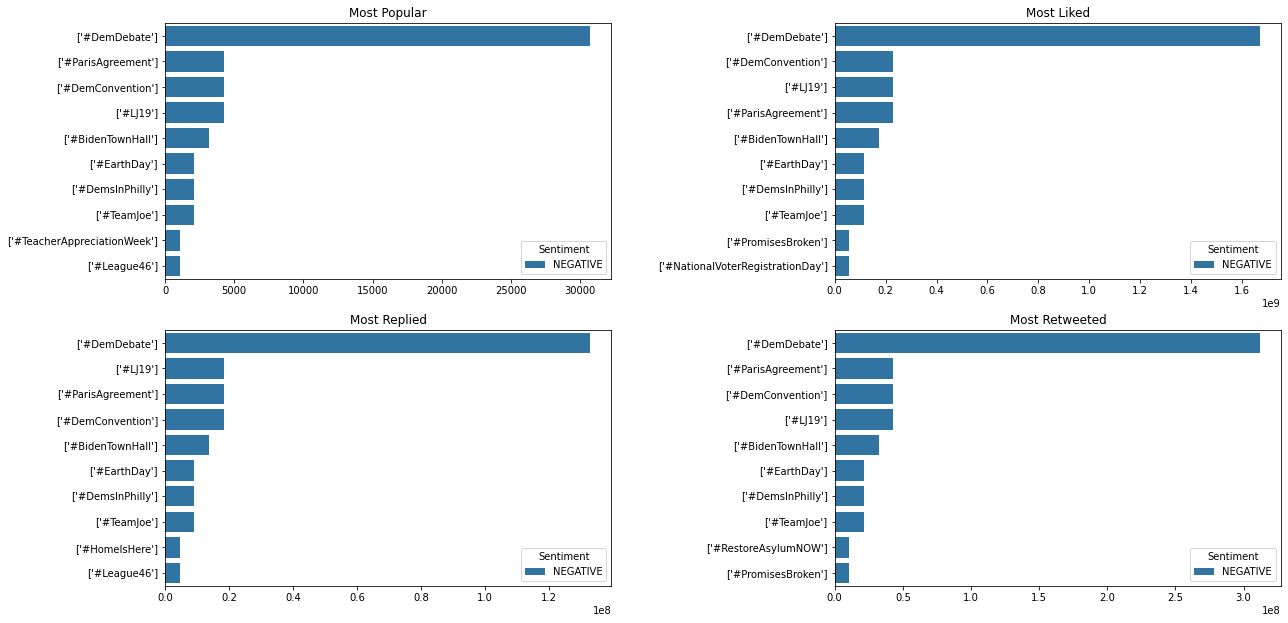

In [59]:
# CUSTOMIZE:
# In the code cell below, do some Exploratory Data Analysis (EDA) by trying to filter
# by various TAGs, see if you can find TAGs that help clarify, focus and reveal interesting
# relationships and trends

#@title Visualize Top TAGs
Filter_TAG = False #@param {type:"boolean"}
TAG = 'Hashtag' #@param ["Hashtag", "Person", "Location", "Organization"]
#@markdown ###Pick how many tags to display per chart:
Top_N = 10 #@param {type:"integer"}

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

# plot the figures
fig = plt.figure(figsize=(20, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.5)

ax1 = fig.add_subplot(321)
sns.barplot(x="Frequency", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax2 = fig.add_subplot(322)
filtered_group = filtered_group.sort_values(['likes_count'], ascending=False)
sns.barplot(x="likes_count", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax3 = fig.add_subplot(323)
filtered_group = filtered_group.sort_values(['replies_count'], ascending=False)
sns.barplot(x="replies_count", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax4 = fig.add_subplot(324)
filtered_group = filtered_group.sort_values(['retweets_count'], ascending=False)
sns.barplot(x="retweets_count", y="tag", data=filtered_group[:Top_N], hue="Sentiment")

ax1.title.set_text('Most Popular')
ax2.title.set_text('Most Liked')
ax3.title.set_text('Most Replied')
ax4.title.set_text('Most Retweeted')

ax1.set_ylabel('')    
ax1.set_xlabel('')
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax4.set_ylabel('')    
ax4.set_xlabel('')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


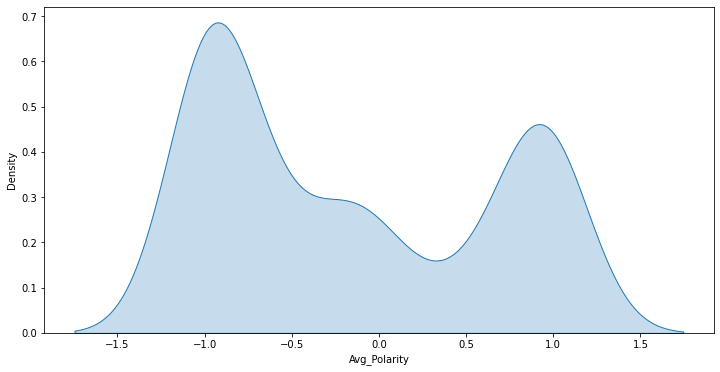

In [60]:
# Get the average polarity description

fig = plt.figure(figsize=(12, 6))
sns.distplot(filtered_group['Avg_Polarity'], hist=False, kde_kws={"shade": True})

## Word Cloud

Let's build a Word Cloud based on these metrics. 

Since I am interested in Seattle, I am going to use overlay the Seattle city skyline view over my Word Cloud. 
You can change this by selecting a different Mask option from the drop down.

Images for Masks can be found at:

http://clipart-library.com/clipart/2099977.htm

https://needpix.com

In [61]:
# CUSTOMIZE: Find a *.jpg image that would make an appropriate silhouette for your wordcloud of tweets
#            and !wget it below

# download mask images
!wget http://clipart-library.com/img/2099977.jpg -O seattle.jpg
!wget https://storage.needpix.com/rsynced_images/trotting-horse-silhouette.jpg -O horse.jpg
!wget https://storage.needpix.com/rsynced_images/black-balloon.jpg -O balloon.jpg
  
clear_output()

In [73]:
#@title Customize Your Word Cloud For Top TAGs
Metric = 'Most Popular' #@param ["Most Popular", "Most Liked", "Most Replied", "Most Retweeted"]
#@markdown
Filter_TAG = False #@param {type:"boolean"}
##@markdown
TAG = 'Location' #@param ["Hashtag", "Person", "Location", "Organization"]
Mask = 'Rectangle' #@param ["Rectangle", "Seattle", "Balloon", "Horse"]

# CUSTOMIZE: edit Mask and 'if MASK' lines in this code block to 
#            use your more appropriate silhouette image for your wordcloud

# get correct Metric value
if Metric == 'Most Popular':
   Metric = 'Frequency'
elif Metric == 'Most Liked':
   Metric = 'Total_Likes'
elif Metric == 'Most Replied':
   Metric = 'Total_Replies'
elif Metric == 'Most Retweeted':
   Metric = 'Total_Retweets'    

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

countDict = {}

for index, row in filtered_group.iterrows():
  if row[Metric] == 0:
    row[Metric] = 1
  countDict.update( {row['tag'] : row[Metric]} )
  
if Mask == 'Seattle':
  Mask = np.array(Image.open("seattle.jpg"))
elif Mask == 'Rectangle':
  Mask = np.array(Image.new('RGB', (800,600), (0, 0, 0)))
elif Mask == 'Horse':
  Mask = np.array(Image.open("horse.png"))
elif Mask == 'Balloon':
  Mask = np.array(Image.open("balloon.jpg"))

clear_output()

# Generate Word Cloud
wordcloud = WordCloud(
    max_words=100,
#     max_font_size=50,
    height=300,
    width=800,
    background_color = 'white',
    mask=Mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords = STOPWORDS).generate_from_frequencies(countDict)
fig = plt.figure(
    figsize = (18, 18),
    )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# CUSTOMIZE: set file_name_wordcloud
file_name_wordcloud = 'tweets_wordcloud.png'
plt.savefig(file_name_wordcloud)

AttributeError: ignored

In [65]:
# see saved word cloud
!ls *.png

tweets_wordcloud.png


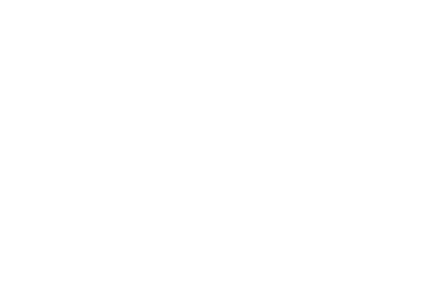

In [76]:
# ERROR: Name collision with PIL library
#  Fix to read and display image 

# from IPython.display import Image
# Image('tweets_wordcloud.png')

In [70]:
%%html
<img src='tweets_wordcloud.png'>

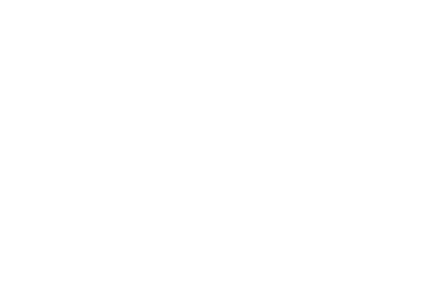

In [68]:
from IPython.display import Image
# Image(file_name_wordcloud.png)
Image('tweets_wordcloud.png')
%%html
<img src='/nbextensions/image.png' />

# **3. NLP Analysis**

Options

* Sentiment Analysis (FastText and/or VADER)
* Named Entity Recognition (NER using flair)

# **3. Write Reports to Output files**

In [ ]:
# Create unique output filename using current datetime stamp

file_name_edaviz = ('edaviz_' + file_name_all.split('.')[0] + '.html') # 'tweets_combined_20201201-012404.csv'
print(file_name_edaviz)

In [ ]:
profile_report = combined_df.profile_report(html={"style": {"full_width": True}})
profile_report.to_file(file_name_edaviz)

In [ ]:
!ls eda_viz*

In [ ]:
# Option #2 to display Pandas-Profiling Report

# import IPython
# IPython.display.HTML(filename=file_name_edaviz)

In [ ]:
# Option #3 to display Pandas-Profiling Report

"""
profile_report = combined_df.profile_report(
    explorative=True, html={"style": {"full_width": True}}
)
profile_report
"""